# Evalaute Velocity and Direction Dependence
The goal of this notebook is to explore the velocity and direction dependence of stopping power, as predicted by the ML model

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from stopping_power_ml.integrator import TrajectoryIntegrator
import pickle as pkl
import pandas as pd
import numpy as np
import keras
import os

Using TensorFlow backend.
/home/lward/miniconda3/envs/ml_tddft/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lward/miniconda3/envs/ml_tddft/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lward/miniconda3/envs/ml_tddft/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lward/mi

## Load in the Model and Featurizer
The model is saved in Keras h5, and the featurizer is in the root directory

In [2]:
model = keras.models.load_model('model-random-and-channel.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [3]:
with open('featurizer.pkl', 'rb') as fp:
    featurizers = pkl.load(fp)

In [4]:
start_frame = pkl.load(open(os.path.join('..', 'al_starting_frame.pkl'), 'rb'))

In [5]:
channel_data = pd.read_pickle(os.path.join('data', 'channel_traj.pkl')).query('average_range')

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 19)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                360       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                608       
_________________________________________________________________
dense_3 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 200       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 15        
__________

## Make the Trajectory Integration Tool
This will black box the annoying parts of making the trajectories

In [7]:
traj_int = TrajectoryIntegrator(start_frame, model, featurizers)

## Evaluate Channel and Off Channel at Many Velocities
See how smoothly it varies and whether the difference between channel/not channel increases at higher velocities

In [8]:
channel_stopping = []
for gid, group in channel_data.groupby('directory'):
    channel_stopping.append({
        'velocity': group['velocity_mag'].mean(),
        'stopping': group['force'].mean()
    })
channel_stopping = pd.DataFrame(channel_stopping)

In [9]:
%%time
velocities = np.linspace(0.1, 8, 32)
stopping_power = [
    traj_int.compute_stopping_power([0, 0.75, 0.75], [1, 0, 0], v)[0]
    for v in velocities
]

CPU times: user 12.7 s, sys: 14 s, total: 26.7 s
Wall time: 8.87 s


Run an off-channel trajecotory. I picked one that gives a pretty high stopping power

In [10]:
%%time
stopping_power_ooc = [
    traj_int.compute_stopping_power([0, 0.75, 0.75], [4, 2, 1], v)[0]
    for v in velocities
]

CPU times: user 6min 23s, sys: 6min 55s, total: 13min 19s
Wall time: 4min 25s


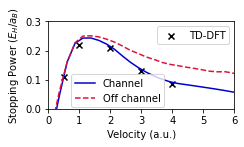

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2))

ch, = ax.plot(velocities, stopping_power, color='mediumblue', label='Channel')
och, = ax.plot(velocities, stopping_power_ooc, '--', color='crimson', label='Off Channel')

# Add in the points for the channel
tddft = ax.scatter(channel_stopping['velocity'], channel_stopping['stopping'], marker='x',
                   facecolor='k', edgecolor='k', label='TD-DFT')

ax.set_xlabel('Velocity (a.u.)')
ax.set_ylabel('Stopping Power ($E_H / a_B$)')
ax.set_ylim(0, 0.3)
ax.set_xlim(0, 6)

l1 = ax.legend((ch, och), ('Channel', 'Off channel'), loc=(0.12, 0.02))
ax.add_artist(l1)
ax.legend((tddft,), ('TD-DFT',))

fig.tight_layout()
fig.savefig(os.path.join('figures', 'on-vs-off-channel-multivelocity.png'), dpi=320)

*Finding*: The stopping power doesn't go to (0, 0), and does seem like it will converge to 0. But, the model does capture that the low velocity regime is linear and the difference between the channel and off chanell gets bigger at higher velocities before merging again at very high velocities.